<a href="https://colab.research.google.com/github/moo-337/differential-machine-learning/blob/Auto-Call/DifferentialMLTF2_AutoCall_local_vol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/differential-machine-learning/notebooks/blob/master/DifferentialMLTF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Working paper: https://arxiv.org/abs/2005.02347 
GitHub: https://github.com/differential-machine-learning

# Differential Deep Learning

---
Updated for TensorFlow 2
---

---
Antoine Savine, January 2021
---

This notebook implements the novel ideas of *twin networks* and *differential training* from the working paper [Differential Machine Learning](https://arxiv.org/abs/2005.02347) by Brian Huge and [Antoine Savine](https://antoinesavine.com) (2020), and applies them in a few simple contexts, including the reproduction of some results from the paper. In the article, we presented the ideas and discussed the algorithms, but skipped important implementation details best covered in a notebook with code. Those details are dicussed here.    

Although this is a *demonstration* notebook, the algorithms are implemented in self contained, modular and extensible blocks of code. They may be easily extracted, extended and integrated into production systems. Some advanced extensions particularly important in a production context are discussed in the [appendices](https://github.com/differential-machine-learning/appendices/).

The code is based on TensorFlow 1.x. You may run the notebook in a local TensorFlow 1.x enviroment *with GPU support*, also with common libraries like numpy and matplotlib. On Google Colab, the correct version of TensorFlow is automatically selected, and all the necessary libraries are preinstalled. All you need is *enable GPU support*: menu runtime/change runtime type and select hardware accelerator GPU.

We do not further discuss the algorithms covered in the article or fundamentals of TensorFlow (see classic resources like [Geron's textbook](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291), first edition for TensorFlow 1.x). For modern deep learning and best practices, we refer e.g. to [Goodfellow and al's Deep Learning Book](https://www.deeplearningbook.org/) or [Andrew Ng's deep learning lectures](https://www.coursera.org/specializations/deep-learning). 

This notebook was ported on TensorFlow 2 in January 2021. The original TensorFlow 1 notebook will no longer be updated. For now, the notebook runs TensorFlow 1 code in a TensorFlow 2 environment. An upgrade to idiomatic TensorFlow 2 code will be available shortly.

# Imports

In [1]:
try:
    %matplotlib notebook
except Exception:
    pass

# import and test
import tensorflow as tf2
print("TF version =", tf2.__version__)

# we want TF 2.x
assert tf2.__version__ >= "2.0"

# disable eager execution etc
tf = tf2.compat.v1
tf.disable_eager_execution()

# disable annoying warnings
tf.logging.set_verbosity(tf.logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

# make sure we have GPU support
print("GPU support = ", tf.test.is_gpu_available())

# import other useful libs
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
from tqdm import tqdm_notebook
import copy

# representation of real numbers in TF, change here for 32/64 bits
real_type = tf.float32
# real_type = tf.float64

TF version = 2.8.2
GPU support =  True


# Part I : Core Functions

## Feedforward neural network in TensorFlow

This function builds a classic feedforward neural network in TensorFlow, implementing the set of equations $(3)$ from the article. This is classic deep learning code and a direct translation of equations $(3)$ in Python. We tried to keep notations consistent with the paper.

The weights are initialized with TensorFlow's  [variance_scaling_initializer](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/initializers/variance_scaling), implementing the particularly effective [Xavier/Glorot](https://www.deeplearning.ai/ai-notes/initialization/)  initialization strategy, a best practice in modern deep learning. A correct initialization is a key ingredient in an effective practical implementation of deep learning. 

Since the network is initialized randomly, we also implement seed in the interest of reproducibility.

In [2]:
def vanilla_net(
    input_dim,      # dimension of inputs, e.g. 10
    hidden_units,   # units in hidden layers, assumed constant, e.g. 20
    hidden_layers,  # number of hidden layers, e.g. 4
    seed):          # seed for initialization or None for random
    
    # set seed
    tf.set_random_seed(seed)
    
    # input layer
    xs = tf.placeholder(shape=[None, input_dim], dtype=real_type)
    
    # connection weights and biases of hidden layers
    ws = [None]
    bs = [None]
    # layer 0 (input) has no parameters
    
    # layer 0 = input layer
    zs = [xs] # eq.3, l=0
    
    # first hidden layer (index 1)
    # weight matrix
    ws.append(tf.get_variable("w1", [input_dim, hidden_units], \
        initializer = tf.variance_scaling_initializer(), dtype=real_type))
    # bias vector
    bs.append(tf.get_variable("b1", [hidden_units], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # graph
    zs.append(zs[0] @ ws[1] + bs[1]) # eq. 3, l=1
    
    # second hidden layer (index 2) to last (index hidden_layers)
    for l in range(1, hidden_layers): 
        ws.append(tf.get_variable("w%d"%(l+1), [hidden_units, hidden_units], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
        bs.append(tf.get_variable("b%d"%(l+1), [hidden_units], \
            initializer = tf.zeros_initializer(), dtype=real_type))
        zs.append(tf.nn.softplus(zs[l]) @ ws[l+1] + bs[l+1]) # eq. 3, l=2..L-1

    # output layer (index hidden_layers+1)
    ws.append(tf.get_variable("w"+str(hidden_layers+1), [hidden_units, 1], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
    bs.append(tf.get_variable("b"+str(hidden_layers+1), [1], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # eq. 3, l=L
    zs.append(tf.nn.softplus(zs[hidden_layers]) @ ws[hidden_layers+1] + bs[hidden_layers+1]) 
    
    # result = output layer
    ys = zs[hidden_layers+1]
    
    # return input layer, (parameters = weight matrices and bias vectors), 
    # [all layers] and output layer
    return xs, (ws, bs), zs, ys

## Explicit backpropagation and twin network

These functions construct the twin network by explicit backpropagation (eq. $(4)$ in the article). The twin network simultaneously and efficiently predicts values and their differentials to inputs, allowing to train on datasets augmented with differential labels (i.e. gradients of labels to inputs, as explained in the working paper). 

In [3]:
# compute d_output/d_inputs by (explicit) backprop in vanilla net
def backprop(
    weights_and_biases, # 2nd output from vanilla_net() 
    zs):                # 3rd output from vanilla_net()
    
    ws, bs = weights_and_biases
    L = len(zs) - 1
    
    # backpropagation, eq. 4, l=L..1
    zbar = tf.ones_like(zs[L]) # zbar_L = 1
    for l in range(L-1, 0, -1):
        zbar = (zbar @ tf.transpose(ws[l+1])) * tf.nn.sigmoid(zs[l]) # eq. 4
    # for l=0
    zbar = zbar @ tf.transpose(ws[1]) # eq. 4
    
    xbar = zbar # xbar = zbar_0
    
    # dz[L] / dx
    return xbar    

# combined graph for valuation and differentiation
def twin_net(input_dim, hidden_units, hidden_layers, seed):
    
    # first, build the feedforward net
    xs, (ws, bs), zs, ys = vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # then, build its differentiation by backprop
    xbar = backprop((ws, bs), zs)
    
    # return input x, output y and differentials d_y/d_z
    return xs, ys, xbar

## Vanilla training loop

These are classic training loops for the feedforward neural network. As customary in modern deep learning, the training set is traversed in mini-batches, where the cost function is minimized with the best practice [ADAM](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/AdamOptimizer) algorithm. Andrew Ng's deeplearning.ai web site has an [intuitive presentation of various optimization algorithms in deep learning](https://www.deeplearning.ai/ai-notes/optimization/).

In [4]:
def vanilla_training_graph(input_dim, hidden_units, hidden_layers, seed):
    
    # net
    inputs, weights_and_biases, layers, predictions = \
        vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # backprop even though we are not USING differentials for training
    # we still need them to predict derivatives dy_dx 
    derivs_predictions = backprop(weights_and_biases, layers)
    
    # placeholder for labels
    labels = tf.placeholder(shape=[None, 1], dtype=real_type)
    
    # loss 
    loss = tf.losses.mean_squared_error(labels, predictions)
    
    # optimizer
    learning_rate = tf.placeholder(real_type)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary 
    return inputs, labels, predictions, derivs_predictions, learning_rate, loss, optimizer.minimize(loss)

# training loop for one epoch
def vanilla_train_one_epoch(# training graph from vanilla_training_graph()
                            inputs, labels, lr_placeholder, minimizer,   
                            # training set 
                            x_train, y_train,                           
                            # params, left to client code
                            learning_rate, batch_size, session):        
    
    m, n = x_train.shape
    
    # minimization loop over mini-batches
    first = 0
    last = min(batch_size, m)
    while first < m:
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            lr_placeholder: learning_rate
        })
        first = last
        last = min(first + batch_size, m)

## Differential training loop

The apparently similar *differential* training loop implements the main idea from the paper, to train twin networks on datasets augmented with differentials of labels to inputs, by minimization of a combined cost function reflecting errors in both predicted values *and predicted derivatives*:

$$
    c = \alpha c_{\text{val}} + \beta c_{\text{diff}}
$$

where $c_{\text{val}}$ is the classic mean square error (MSE) of predictions to labels and $c_{\text{diff}}$ is the cost of wrong derivatives:

$$
    c_{\text{diff}} = \frac{\sum_{\text{inputs j}} \lambda_j^2 {mse}_j}{\text{num inputs}}
$$

where ${mse}_j$ is the mean squared error of derivatives to input $j$ and the weights $\lambda_j$ normalize derivatives so all the components of the cost have similar magnitudes, as explained in the article. We provide a basic normalization formula for the weights a few cells below, and a complete review of data preparation and weighting in [this appendix](https://github.com/differential-machine-learning/appendices/blob/master/App2-Preprocessing.pdf).




In [5]:
def diff_training_graph(
    # same as vanilla
    input_dim, 
    hidden_units, 
    hidden_layers, 
    seed, 
    # balance relative weight of values and differentials 
    # loss = alpha * MSE(values) + beta * MSE(greeks, lambda_j) 
    # see online appendix
    alpha, 
    beta,
    lambda_j):
    
    # net, now a twin
    inputs, predictions, derivs_predictions = twin_net(input_dim, hidden_units, hidden_layers, seed)
    
    # placeholder for labels, now also derivs labels
    labels = tf.placeholder(shape=[None, 1], dtype=real_type)
    derivs_labels = tf.placeholder(shape=[None, derivs_predictions.shape[1]], dtype=real_type)
    
    # loss, now combined values + derivatives
    loss = alpha * tf.losses.mean_squared_error(labels, predictions) \
    + beta * tf. losses.mean_squared_error(derivs_labels * lambda_j, derivs_predictions * lambda_j)
    
    # optimizer, as vanilla
    learning_rate = tf.placeholder(real_type)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary tensors, including derivatives
    # predictions and labels
    return inputs, labels, derivs_labels, predictions, derivs_predictions, \
            learning_rate, loss, optimizer.minimize(loss)

def diff_train_one_epoch(inputs, labels, derivs_labels, 
                         # graph
                         lr_placeholder, minimizer,             
                         # training set, extended
                         x_train, y_train, dydx_train,          
                         # params
                         learning_rate, batch_size, session):   
    
    m, n = x_train.shape
    
    # minimization loop, now with Greeks
    first = 0
    last = min(batch_size, m)
    while first < m:
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            derivs_labels: dydx_train[first:last],
            lr_placeholder: learning_rate
        })
        first = last
        last = min(first + batch_size, m)

## Combined outer training loop

The outer training loop optimizes the weights of neural approximators for a number of epochs (complete sweeps of the training set). We applied the recent [one-cycle learning rate schedule](https://arxiv.org/abs/1803.09820) of Leslie Smith and found that it considerably accelerates and stabilizes the training of neural networks. 100 epochs is more than sufficient in most practical cases. A convergence and/or cross-validation test may be included for early stopping. Typical training takes around a second on a decent GPU (longer on Colab's shared GPUs). The approximator class, defined next, holds all the necessary data and parameters, along with the TensorFlow graph and computing session.

In [6]:
def train(description,
          # neural approximator
          approximator,              
          # training params
          reinit=True, 
          epochs=100, 
          # one-cycle learning rate schedule
          learning_rate_schedule=[    (0.0, 1.0e-8), \
                                      (0.2, 0.1),    \
                                      (0.6, 0.01),   \
                                      (0.9, 1.0e-6), \
                                      (1.0, 1.0e-8)  ], 
          batches_per_epoch=16,
          min_batch_size=256,
          # callback function and when to call it
          callback=None,           # arbitrary callable
          callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
    # batching
    batch_size = max(min_batch_size, approximator.m // batches_per_epoch)
    
    # one-cycle learning rate sechedule
    lr_schedule_epochs, lr_schedule_rates = zip(*learning_rate_schedule)
            
    # reset
    if reinit:
        approximator.session.run(approximator.initializer)
    
    # callback on epoch 0, if requested
    if callback and 0 in callback_epochs:
        callback(approximator, 0)
        
    # loop on epochs, with progress bar (tqdm)
    for epoch in tqdm_notebook(range(epochs), desc=description):
        
        # interpolate learning rate in cycle
        learning_rate = np.interp(epoch / epochs, lr_schedule_epochs, lr_schedule_rates)
        
        # train one epoch
        
        if not approximator.differential:
        
            vanilla_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                learning_rate, 
                batch_size, 
                approximator.session)
        
        else:
        
            diff_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.derivs_labels,
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                approximator.dy_dx,
                learning_rate, 
                batch_size, 
                approximator.session)
        
        # callback, if requested
        if callback and epoch in callback_epochs:
            callback(approximator, epoch)

    # final callback, if requested
    if callback and epochs in callback_epochs:
        callback(approximator, epochs)        


## Data normalization

The practical performance of neural networks strongly depends on implementation details, like weight initialization and optimization. Another crucial practicality is the *normalization of training data*. We refer to deep learning texbooks for a discussion of the importance of normalization. One reason is that we need hyperparameters like the learning rate schedule to remain constant over datasets. If notional was to be increased by factor 1M all things equal, gradients would be multiplied by 1M too and learning rates would have to be divided by 1M to keep things similar. Normalizing data avoids manual tinkering of hyperparameters for different datasets. All the examples in the paper: the Gaussian basket, the autocallable trade and the netting set, were all approximated with the exact same hyperparameters. This is only possible with normalized datasets. 

We implement below a *basic* normalization strategy, where the training inputs and labels are normalized by mean and standard deviation, with differentials normalized accordingly. The differential weights in the cost function $\lambda_j$ divide costs by the norm of the normalized differentials, keeping similar the magnitude of all the components of the cost.

We can do a lot better, especially with differential labels. We could perform successive changes of basis, combined with filtering strategies, to feed neural networks with data orthonormal in terms of inputs *and* in terms of differentials, highlighting the most significant risk factors and filtering out the irrelevant ones. This is covered in detail in the [this appendix](https://github.com/differential-machine-learning/appendices/blob/master/App2-Preprocessing.pdf), where we discuss novel, and extremely effective data preparation algorithms, exploiting information contained in differential labels to considerably alleviate the load of training neural networks and subsequently, improve training performance and reduce sensitivity to hyperparameters. 

Although the basic normalization implemented here is sufficient for textbook examples, a reliable implementation in production for arbitrary schedules of cash-flows, resilient to very high dimensionality, necessitatesthe more complete data preparation.

Note that the prediction of values and derivatives must be adjusted accordingly: prediction inputs must be normalized, and resulting predictions must be 'un-normalized'. 

In [7]:
# basic data preparation
epsilon = 1.0e-08
def normalize_data(x_raw, y_raw, dydx_raw=None, crop=None):
    
    # crop dataset
    m = crop if crop is not None else x_raw.shape[0]
    x_cropped = x_raw[:m]
    y_cropped = y_raw[:m]
    dycropped_dxcropped = dydx_raw[:m] if dydx_raw is not None else None
    
    # normalize dataset
    x_mean = x_cropped.mean(axis=0)
    x_std = x_cropped.std(axis=0) + epsilon
    x = (x_cropped- x_mean) / x_std
    y_mean = y_cropped.mean(axis=0)
    y_std = y_cropped.std(axis=0) + epsilon
    y = (y_cropped-y_mean) / y_std
    
    # normalize derivatives too
    if dycropped_dxcropped is not None:
        dy_dx = dycropped_dxcropped / y_std * x_std 
        # weights of derivatives in cost function = (quad) mean size
        lambda_j = 1.0 / np.sqrt((dy_dx ** 2).mean(axis=0)).reshape(1, -1)
    else:
        dy_dx = None
        lambda_j = None
    
    return x_mean, x_std, x, y_mean, y_std, y, dy_dx, lambda_j

## Putting it all together

For convenience, we put it all together in a *Neural_Approximator* class. Most of the code should be self explanatory. 

Note that we compute the coefficients $\alpha$ and $\beta$ for balancing cost between values and derivatives in a straightforward manner:

$$
    \alpha = \frac{1}{1 + \lambda n} \text{ and }  \beta = \frac{\lambda n}{1 + \lambda n}
$$

where $n$ is the number of inputs, so an error on a derivative has a weight similar to a value error, and $\lambda$ is a hyperparameter without significant effect, as explained in the paper, and left to 1, safe for debugging.

We implement a simple, feedforward architecture with 4 hidden layers of 20 units, throughout our tests. We kept the same architecture in production, with the addition of a *wide and deep* layer, inspired by [Google](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html) and discussed in the [this appendix](https://github.com/differential-machine-learning/appendices/blob/master/App4-UnsupervisedTraining.pdf).

In [8]:
class Neural_Approximator():
    
    def __init__(self, x_raw, y_raw, 
                 dydx_raw=None):      # derivatives labels, 
       
        self.x_raw = x_raw
        self.y_raw = y_raw
        self.dydx_raw = dydx_raw
        
        # tensorflow logic
        self.graph = None
        self.session = None
                        
    def __del__(self):
        if self.session is not None:
            self.session.close()
        
    def build_graph(self,
                differential,       # differential or not           
                lam,                # balance cost between values and derivs  
                hidden_units, 
                hidden_layers, 
                weight_seed):
        
        # first, deal with tensorflow logic
        if self.session is not None:
            self.session.close()

        self.graph = tf.Graph()
        
        with self.graph.as_default():
        
            # build the graph, either vanilla or differential
            self.differential = differential
            
            if not differential:
            # vanilla 
                
                self.inputs, \
                self.labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer \
                = vanilla_training_graph(self.n, hidden_units, hidden_layers, weight_seed)
                    
            else:
            # differential
            
                if self.dy_dx is None:
                    raise Exception("No differential labels for differential training graph")
            
                self.alpha = 1.0 / (1.0 + lam * self.n)
                self.beta = 1.0 - self.alpha
                
                self.inputs, \
                self.labels, \
                self.derivs_labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer = diff_training_graph(self.n, hidden_units, \
                                                     hidden_layers, weight_seed, \
                                                     self.alpha, self.beta, self.lambda_j)
        
            # global initializer
            self.initializer = tf.global_variables_initializer()
            
        # done
        self.graph.finalize()
        self.session = tf.Session(graph=self.graph)
                        
    # prepare for training with m examples, standard or differential
    def prepare(self, 
                m, 
                differential,
                lam=1,              # balance cost between values and derivs  
                # standard architecture
                hidden_units=20, 
                hidden_layers=4, 
                weight_seed=None):

        # prepare dataset
        self.x_mean, self.x_std, self.x, self.y_mean, self.y_std, self.y, self.dy_dx, self.lambda_j = \
            normalize_data(self.x_raw, self.y_raw, self.dydx_raw, m)
        
        # build graph        
        self.m, self.n = self.x.shape        
        self.build_graph(differential, lam, hidden_units, hidden_layers, weight_seed)
        
    def train(self,            
              description="training",
              # training params
              reinit=True, 
              epochs=100, 
              # one-cycle learning rate schedule
              learning_rate_schedule=[
                  (0.0, 1.0e-8), 
                  (0.2, 0.1), 
                  (0.6, 0.01), 
                  (0.9, 1.0e-6), 
                  (1.0, 1.0e-8)], 
              batches_per_epoch=16,
              min_batch_size=256,
              # callback and when to call it
              # we don't use callbacks, but this is very useful, e.g. for debugging
              callback=None,           # arbitrary callable
              callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
        train(description, 
              self, 
              reinit, 
              epochs, 
              learning_rate_schedule, 
              batches_per_epoch, 
              min_batch_size,
              callback, 
              callback_epochs)
     
    def predict_values(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std 
        # predict scaled
        y_scaled = self.session.run(self.predictions, feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        return y

    def predict_values_and_derivs(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std
        # predict scaled
        y_scaled, dyscaled_dxscaled = self.session.run(
            [self.predictions, self.derivs_predictions], 
            feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        dydx = self.y_std / self.x_std * dyscaled_dxscaled
        return y, dydx

In [9]:
def test(generator, 
         sizes, 
         nTest, 
         simulSeed=None, 
         testSeed=None, 
         weightSeed=None, 
         deltidx=0):

    # simulation
    print("simulating training, valid and test sets")
    xTrain, yTrain, dydxTrain = generator.trainingSet(max(sizes), seed=simulSeed)
    xTest, xAxis, yTest, dydxTest, vegas = generator.testSet(num=nTest, seed=testSeed)
    print("done")

    # neural approximator
    print("initializing neural appropximator")
    regressor = Neural_Approximator(xTrain, yTrain, dydxTrain)
    print("done")
    
    predvalues = {}    
    preddeltas = {}
    for size in sizes:        
            
        print("\nsize %d" % size)
        regressor.prepare(size, False, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("standard training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("standard", size)] = predictions
        preddeltas[("standard", size)] = deltas[:, deltidx]
        t1 = time.time()
        
        regressor.prepare(size, True, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("differential training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("differential", size)] = predictions
        preddeltas[("differential", size)] = deltas[:, deltidx]
        t1 = time.time()
        
    return xAxis, yTest, dydxTest[:, deltidx], vegas, predvalues, preddeltas, regressor

def graph(title, 
          predictions, 
          xAxis, 
          xAxisName, 
          yAxisName, 
          targets, 
          sizes, 
          computeRmse=False, 
          weights=None):
    
    numRows = len(sizes)
    numCols = 2

    fig, ax = plt.subplots(numRows, numCols, squeeze=False)
    fig.set_size_inches(4 * numCols + 1.5, 4 * numRows)

    for i, size in enumerate(sizes):
        ax[i,0].annotate("size %d" % size, xy=(0, 0.5), 
          xytext=(-ax[i,0].yaxis.labelpad-5, 0),
          xycoords=ax[i,0].yaxis.label, textcoords='offset points',
          ha='right', va='center')
  
    ax[0,0].set_title("standard")
    ax[0,1].set_title("differential")
    
    for i, size in enumerate(sizes):        
        for j, regType, in enumerate(["standard", "differential"]):

            if computeRmse:
                errors = 100 * (predictions[(regType, size)] - targets)
                if weights is not None:
                    errors /= weights
                rmse = np.sqrt((errors ** 2).mean(axis=0))
                t = "rmse %.2f" % rmse
            else:
                t = xAxisName
                
            ax[i,j].set_xlabel(t)            
            ax[i,j].set_ylabel(yAxisName)

            ax[i,j].plot(xAxis*100, predictions[(regType, size)]*100, 'co', \
                         markersize=2, markerfacecolor='white', label="predicted")
            ax[i,j].plot(xAxis*100, targets*100, 'r.', markersize=0.5, label='targets')

            ax[i,j].legend(prop={'size': 8}, loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle("% s -- %s" % (title, yAxisName), fontsize=16)
    plt.show()


In [20]:
# generates a random correlation matrix
def genCorrel(n):
    randoms = np.random.uniform(low=-1., high=1., size=(2*n, n))
    cov = randoms.T @ randoms
    invvols = np.diag(1. / np.sqrt(np.diagonal(cov)))
    return np.linalg.multi_dot([invvols, cov, invvols])

class AutoCallBS:
    
    def __init__(self, 
                 n,
                 n_exercise,
                 T1=1, 
                 Tm=4, 
                 K=[0.9, 0.85, 0.8, 0.7],
                 cpn=[0.03, 0.06, 0.09, 0.12],
                 volMult=1.5):
        
        self.n = n
        self.n_exercise = n_exercise
        self.T1 = T1
        self.Tm = Tm
        self.K = K
        self.volMult = volMult
        self.cpn = cpn
                
    # training set: returns S1 (mxn), AC2 (mx1) and dAC2/dS1 (mxn)
    def trainingSet(self, m, anti=True, seed=None, bktVol=0.2):
    
        np.random.seed(seed)

        # spots all currently 1, without loss of generality
        self.S0 = np.repeat(1., self.n)
        # random correl
        self.corr = genCorrel(self.n)

        # random weights
        self.a = np.random.uniform(low=1., high=10., size=self.n)
        self.a /= np.sum(self.a)
        # random vols
        vols = np.random.uniform(low=5., high = 50., size = self.n)
        # normalize vols for a given volatility of basket, 
        # helps with charts without loss of generality
        avols = (self.a * vols).reshape((-1,1))
        v = np.sqrt(np.linalg.multi_dot([avols.T, self.corr, avols]).reshape(1))
        self.vols = vols * bktVol / v
        self.bktVol = bktVol

        # Choleski etc. for simulation
        diagv = np.diag(self.vols)
        self.cov = np.linalg.multi_dot([diagv, self.corr, diagv])
        self.chol = np.linalg.cholesky(self.cov) * np.sqrt((self.Tm - self.T1)/self.n_exercise)
        # increase vols for simulation of X so we have more samples in the wings
        self.chol0 = self.chol * self.volMult * np.sqrt(self.T1/(self.Tm - self.T1)*self.n_exercise)
        # simulations
        normals = np.random.normal(size=[self.n_exercise + 1, m, self.n])
        # R1 = np.exp(-0.5*(self.vols*self.volMult)**2*self.T1 + normals[0, :, :] @ self.chol0.T)
        R1 = np.random.uniform(low=0.3, high = 1.5, size=[m, self.n])
        S1 = self.S0 * R1
        R_dic = {}
        R_dic['R1'] = R1
        S_dic = {}
        S_dic['S1'] = S1
        for t_i in range(self.n_exercise):
            R_dic['R{}'.format(t_i+2)] = np.exp(-0.5*self.vols**2*(self.Tm - self.T1)/self.n_exercise + normals[t_i+1, :, :] @ self.chol.T)
            S_dic['S{}'.format(t_i+2)] = S_dic['S{}'.format(t_i+1)] * R_dic['R{}'.format(t_i+2)]
        
        pay, refund_idx_dict, oh_value = self.payoff(S_dic)
        smoking_adj = 1
        for t_i in reversed(range(self.n_exercise)):
            smoking_adj *= R_dic['R{}'.format(t_i+2)] / R_dic['R{}'.format(t_i+1)]

        # two antithetic paths
        if anti:
            Ra_dic = {}
            Ra_dic['R1'] = R1
            Sa_dic = {}
            Sa_dic['S1'] = S1
            
            for t_i in range(self.n_exercise):
                Ra_dic['R{}'.format(t_i+2)] = np.exp(-0.5*self.vols**2*(self.Tm - self.T1)/self.n_exercise - normals[t_i+1, :, :] @ self.chol.T)
                Sa_dic['S{}'.format(t_i+2)] = Sa_dic['S{}'.format(t_i+1)] * Ra_dic['R{}'.format(t_i+2)]
                
            smoking_adj_a = 1
            for t_i in reversed(range(self.n_exercise)):
                smoking_adj_a *= Ra_dic['R{}'.format(t_i+2)] / Ra_dic['R{}'.format(t_i+1)]

            paya, refund_idx_dict_a, oh_value = self.payoff(Sa_dic)
            for i, key in enumerate(refund_idx_dict):
                print('probability of path {}'.format(key), np.mean(refund_idx_dict[key]))
                print('probability of antipath {}'.format(key), np.mean(refund_idx_dict_a[key]))
            
            X = S1
            Y = 0.5 * (pay + paya)

            STm = S_dic['S{}'.format(self.n_exercise+1)]
            STma = Sa_dic['S{}'.format(self.n_exercise+1)]
            
            # differentials
            # Z1 = (refund_idx_dict['norefund'].reshape((-1,1)) + refund_idx_dict['ohidx'].reshape((-1,1)) * oh_value) * np.min(STm, axis=1).reshape((-1,1)) / S1 # smoking_adjoints
            # Z2 = (refund_idx_dict_a['norefund'].reshape((-1,1)) + refund_idx_dict_a['ohidx'].reshape((-1,1)) * oh_value) * np.min(STma, axis=1).reshape((-1,1)) / S1
            Z1 =  np.where(np.min(STm, axis=1).reshape((-1,1)) == STm, 1.0, 0.0) * (refund_idx_dict['norefund'].reshape((-1,1)) + refund_idx_dict['ohidx'].reshape((-1,1)) * oh_value) * smoking_adj #STm / S1 
            Z2 =  np.where(np.min(STma, axis=1).reshape((-1,1)) == STma, 1.0, 0.0) * (refund_idx_dict_a['norefund'].reshape((-1,1)) + refund_idx_dict_a['ohidx'].reshape((-1,1)) * oh_value) * smoking_adj_a #STma / S1

            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay

            STm = S_dic['S{}'.format(self.n_exercise+1)]

            # differentials
            Z =  np.where(np.min(STm, axis=1).reshape((-1,1)) == STm, 1.0, 0.0) * refund_idx_dict['norefund'].reshape((-1,1)) * STm / S1
            # Z = unrefund_idx.reshape((-1,1)) * np.min(STm, axis=1).reshape((-1,1)) / S1 # smoking_adjoints
        return X, Y.reshape(-1,1), Z

    def payoff(self, S_dic):
        #check validation
        if len(S_dic) != self.n_exercise + 1:
            print("path generate error")
            exit()
        m = len(S_dic['S1'])
        norefund_idx = np.ones_like(S_dic['S1'][:, 0])
        pay = np.zeros_like(S_dic['S1'][:, 0])
        prob = 0
        refund_idx_dict = {}
        for i, key in enumerate(S_dic):
            if key != 'S1':
                # print(i, self.K[i-1], key)
                price = S_dic[key]
                price *= norefund_idx.reshape((-1,1))
                # refund_idx = np.all(np.maximum(0, price - self.K[i-1]*S_dic['S1']), axis=1).astype(np.float64)
                refund_idx = np.all(np.maximum(0, price - self.K[i-1]), axis=1).astype(np.float64)
                refund_idx_dict[key] = refund_idx
                prob += sum(refund_idx)
                pay += refund_idx * (1+self.cpn[i-1])
                norefund_idx -= refund_idx

        unrefund_price = np.min(price * norefund_idx.reshape((-1,1)), axis=1)
        oh_value = 10.
        K_star = (1 + self.cpn[-1] - oh_value*self.K[-1])/(1-oh_value)
        oh_idx = np.where(unrefund_price >= K_star, 1.0, 0.0)
        refund_idx_dict['ohidx'] = oh_idx
        norefund_idx -= oh_idx 
        refund_idx_dict['norefund'] = norefund_idx
        prob += sum(norefund_idx + oh_idx)
        pay += np.min(price * norefund_idx.reshape((-1,1)), axis=1)
        pay += ((unrefund_price - K_star) * oh_value + K_star) * oh_idx

        if prob/m != 1.:
            print('payoff probability is not 1', prob)
            exit()
        return pay, refund_idx_dict, oh_value

    def pricing_AutoCall_mc(self, spots, normals):
        
        R_dic = {}
        S_dic = {}
        S_dic['S1'] = np.ones(shape=(100000, self.n)) * spots.reshape((1, -1))

        for t_i in range(self.n_exercise):
            R_dic['R{}'.format(t_i+2)] = np.exp(-0.5*self.vols**2*(self.Tm - self.T1)/self.n_exercise + normals[t_i, :, :] @ self.chol.T)
            S_dic['S{}'.format(t_i+2)] = S_dic['S{}'.format(t_i+1)] * R_dic['R{}'.format(t_i+2)]
        # anti
        Ra_dic = {}
        Sa_dic = {}
        Sa_dic['S1'] = S_dic['S1']
        
        for t_i in range(self.n_exercise):
            Ra_dic['R{}'.format(t_i+2)] = np.exp(-0.5*self.vols**2*(self.Tm - self.T1)/self.n_exercise - normals[t_i, :, :] @ self.chol.T)
            Sa_dic['S{}'.format(t_i+2)] = Sa_dic['S{}'.format(t_i+1)] * Ra_dic['R{}'.format(t_i+2)]      
        
        pay, refund_idx_dict, oh_value = self.payoff(S_dic)
        paya, refund_idx_dict_a, oh_value = self.payoff(Sa_dic)
        
        return np.mean(pay + paya) * 0.5
        
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas
    def testSet(self, lower=0.5, upper=1.50, num=4096, seed=None):
        
        np.random.seed(seed)
        # adjust lower and upper for dimension
        adj = 1 + 0.5 * np.sqrt((self.n-1)*(upper-lower)/12)
        adj_lower = 1.0 - (1.0-lower) * adj
        adj_upper = 1.0 + (upper - 1.0) * adj
        # draw spots
        spots = np.random.uniform(low=adj_lower, high = adj_upper, size=(num, self.n))
        normals = np.random.normal(size=[self.n_exercise, 100000, self.n])
        # compute prices, deltas and vegas
        prices = np.zeros(shape=(num, 1))
        deltas = np.zeros(shape=(num, 1))
        fones = np.ones(shape=(1, self.n))
        fones[0][0] += 0.01 
        bones = np.ones(shape=(1, self.n))
        bones[0][0] -= 0.01

        f1spots = spots * fones
        b1spots = spots * bones

        for i in range(num):
            prices[i] += self.pricing_AutoCall_mc(spots[i], normals)
            deltas[i] += (self.pricing_AutoCall_mc(f1spots[i], normals) - self.pricing_AutoCall_mc(b1spots[i], normals)) / (2*spots[i][0]*0.01)
        prices = prices.reshape((-1, 1))
        deltas = deltas.reshape((-1, 1))
        vegas = 0
        return spots, spots, prices, deltas, vegas

In [21]:

# simulation set sizes to perform
sizes = [100000, 200000]

# show delta?
showDeltas = True
deltidx = 0 # show delta to first stock

# seed
simulSeed = 605
# simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
testSeed = None
weightSeed = None
    
# number of test scenarios
nTest = 40    

# go
generator = AutoCallBS(3, 4)
xAxis, yTest, dydxTest, vegas, values, deltas, regressor = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 605
simulating training, valid and test sets
probability of path S2 0.113145
probability of antipath S2 0.11297
probability of path S3 0.045135
probability of antipath S3 0.04554
probability of path S4 0.040525
probability of antipath S4 0.04
probability of path S5 0.06714
probability of antipath S5 0.06657
probability of path ohidx 0.034015
probability of antipath ohidx 0.03428
probability of path norefund 0.70004
probability of antipath norefund 0.70064
done
initializing neural appropximator
done

size 100000


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]


size 200000


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
%matplotlib inline

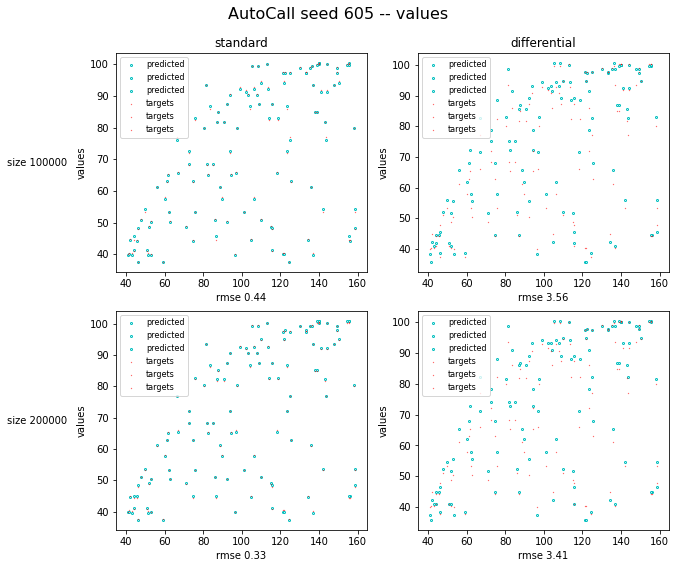

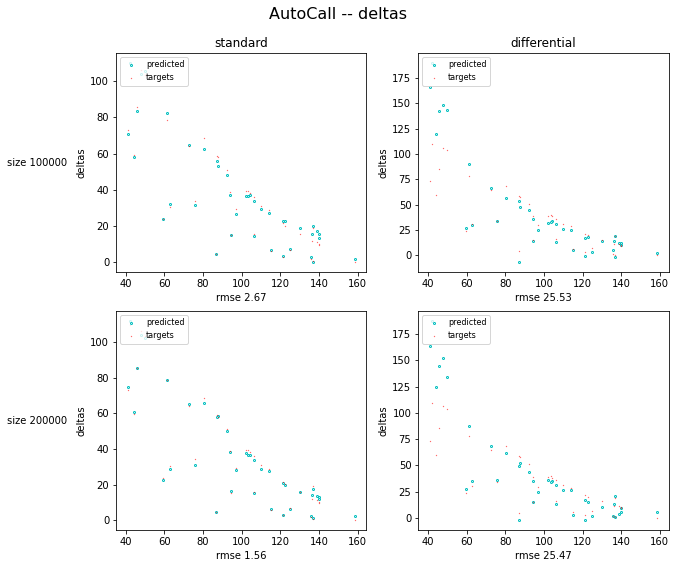

In [22]:
# show predicitions
graph("AutoCall seed %d" % simulSeed , values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("AutoCall", deltas, xAxis[:,0], "", "deltas", dydxTest, sizes, True)

In [ ]:
# show predicitions
graph("AutoCall seed %d" % simulSeed , values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("AutoCall", deltas, xAxis[:,0], "", "deltas", dydxTest, sizes, True)

In [ ]:
# show predicitions
graph("AutoCall seed %d" % simulSeed , values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("AutoCall", deltas, xAxis[:,0], "", "deltas", dydxTest, sizes, True)

In [ ]:
# show predicitions
graph("AutoCall seed %d" % simulSeed , values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("AutoCall", deltas, xAxis[:,0], "", "deltas", dydxTest, sizes, True)

In [ ]:
# show predicitions
graph("AutoCall seed %d" % simulSeed , values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("AutoCall", deltas, xAxis[:,0], "", "deltas", dydxTest, sizes, True)

In [ ]:
ones = np.ones((100, 3))

for i in range(100):
    ones[i][0] = (i+1)*0.01 + 0.5

values_1, deltas_1 = regressor.predict_values_and_derivs(ones)

normals = np.random.normal(size=[4, 100000, 3])


targets = np.zeros_like(values_1)
targets_delta = np.zeros_like(values_1)
for i in range(100):
    targets[i] += generator.pricing_AutoCall_mc(ones[i], normals)

(values_1 - targets)*10000

In [ ]:
generator.vols

In [ ]:
regressor.x_mean, regressor.x_std

In [ ]:
regressor.x_raw

In [ ]:
regressor.y_raw

In [ ]:
regressor.dydx_raw